**Etapa 1: Análise das Pesquisas de Atendimento aos Usuários**

In [1]:
# instalação de pacotes necessários
install.packages(c("cartography", "openxlsx", "reshape2", "rstatix",
"syuzhet", "fmsb", "tm", "wordcloud", "RColorBrewer", "gridExtra"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘proxy’, ‘wk’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘e1071’, ‘terra’, ‘s2’, ‘units’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘classInt’, ‘png’, ‘raster’, ‘sf’, ‘sp’, ‘plyr’, ‘corrplot’, ‘car’, ‘textshape’, ‘NLP’, ‘zoo’, ‘dtt’, ‘slam’, ‘BH’




In [2]:
library(readxl) # pacote necessário para leitura de planilhas do Excel
library(tidyverse) # pacote para manipulação e análise de dados
library(scales) # pacote para formatação e ajuste de escalas em gráficos
library(cartography) # pacote para criação de mapas temáticos e visualização geoespacial
library(RColorBrewer) # pacote para seleção e aplicação de paletas de cores
library(sf) # pacote para manipulação e análise de dados espaciais
library(openxlsx) # pacote para leitura, escrita e manipulação de planilhas Excel
library(syuzhet) # pacote para análise de sentimentos e emoções em textos
library(fmsb) # pacote para criar gráficos de radar
library(reshape2) # pacote para transformação de dados
library(rstatix) # pacote para análise estatística de dados
library(tm) # pacote para processamento e análise de texto (mineração de texto)
library(wordcloud) # pacote para criação de nuvens de palavras
library(gridExtra) # pacote para criação de layouts com múltiplos gráfico

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


This project is in maintenance mode. 
Core functionalities of `cartography` can be found in `mapsf`.
https://riatelab.github.io/mapsf/

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE


Attaching package: ‘syuzhet’


The following object is masked from ‘package:scales’:

    rescale




In [3]:
# função para baixar o banco de dados relacionao ao ''Atendimento'' do GitHub
download.file("https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-caesb/db_atendimento.xlsx",
destfile = "db_atendimento.xlsx", mode = "wb")

# função para baixar o banco de dados relacionao à ''Pesquisa'' do GitHub
download.file("https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-caesb/db_pesquisa.xlsx",
destfile = "db_pesquisa.xlsx", mode = "wb")

# download do arquivo necessário para confeccionar o mapa do DF
url_shx <- "https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-shapefiles/shapefile_distrito_federal.shx"
url_shp <- "https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-shapefiles/shapefile_distrito_federal.shp"
url_dbf <- "https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-shapefiles/shapefile_distrito_federal.dbf"

arquivo_shx <- "shapefile_distrito_federal.shx"
arquivo_shp <- "shapefile_distrito_federal.shp"
arquivo_dbf <- "shapefile_distrito_federal.dbf"

download.file(url_shx, arquivo_shx, mode = "wb")
download.file(url_shp, arquivo_shp, mode = "wb")
download.file(url_dbf, arquivo_dbf, mode = "wb")

In [4]:
# função para efetuar a leitura da planilha do Excel
base_atendimento <- read_xlsx("db_atendimento.xlsx",
col_types = c("numeric", "text", "numeric", "text", "text", "text", "text", "text", "text", "text", "text", "numeric"))

# função para obter um resumo estatístico do banco de dados
summary(base_atendimento)

      ano           mes                 dia        tipo_manifestacao 
 Min.   :2019   Length:122511      Min.   : 1.00   Length:122511     
 1st Qu.:2020   Class :character   1st Qu.: 8.00   Class :character  
 Median :2021   Mode  :character   Median :16.00   Mode  :character  
 Mean   :2021                      Mean   :15.94                     
 3rd Qu.:2022                      3rd Qu.:23.00                     
 Max.   :2023                      Max.   :31.00                     
 grupo_servico        servico             cidade          canal_comunicacao 
 Length:122511      Length:122511      Length:122511      Length:122511     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                

In [5]:
# quantidade anual de manifestações
registros_anual <- base_atendimento %>%
  group_by(ano) %>%
  summarise(soma_manifestacao = sum(qtd_manifestacao, na.rm = TRUE))

print(registros_anual)

# A tibble: 5 × 2
    ano soma_manifestacao
  <dbl>             <dbl>
1  2019             19963
2  2020             31463
3  2021             24361
4  2022             28892
5  2023             32293


In [6]:
# comandos usados para substituir o mês por extenso pelo seu respectivo valor numérico
meses_extenso <- c("janeiro" = 1, "fevereiro" = 2, "março" = 3, "abril" = 4,
                   "maio" = 5, "junho" = 6, "julho" = 7, "agosto" = 8,
                   "setembro" = 9, "outubro" = 10, "novembro" = 11, "dezembro" = 12)

base_atendimento$mes_numero <- meses_extenso[base_atendimento$mes]

# comandos utilizados para criar uma base de dados que some as quantidades de registros mensais de cada ano
atendimento_agrupado <- base_atendimento %>%
  group_by(ano, mes_numero) %>%
  summarise(quantidade_total = sum(qtd_manifestacao)) %>%
  ungroup()

atendimento_agrupado$data <- make_date(atendimento_agrupado$ano, atendimento_agrupado$mes_numero, 1)

`summarise()` has grouped output by 'ano'. You can override using the `.groups`
argument.


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


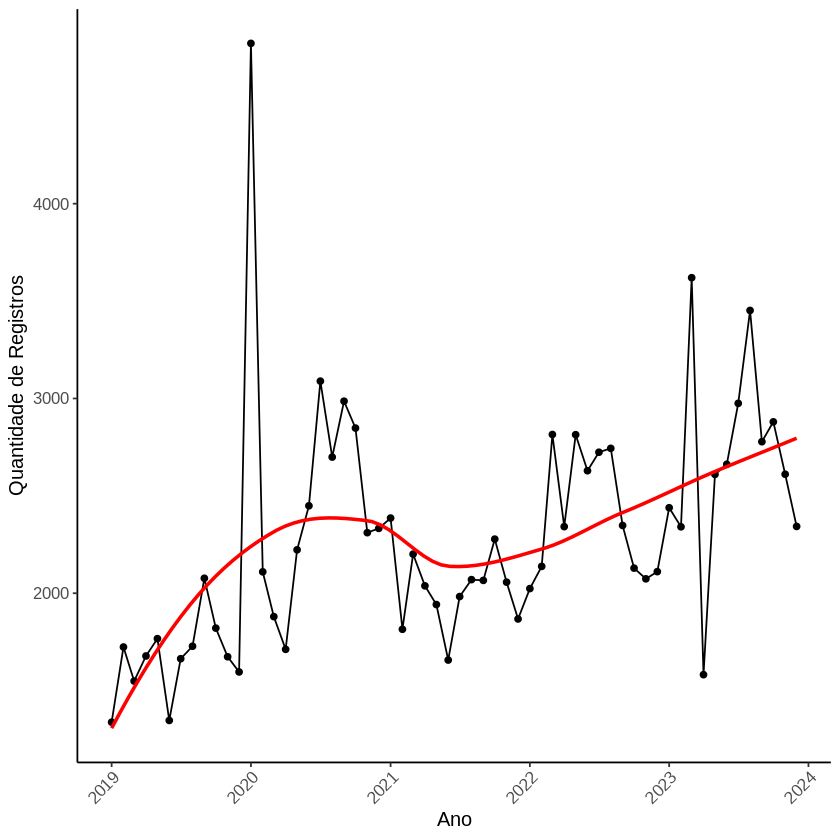

In [7]:
# gráfico da evolução mensal da quantidade de registros ao longo dos anos
ggplot(atendimento_agrupado, aes(x = data, y = quantidade_total)) +
  geom_line() +
  geom_point(color = "black", size = 1.5) +
  theme_classic() +
  labs(x = "Ano",
       y = "Quantidade de Registros") +
  scale_x_date(
    breaks = seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"),
    labels = format(seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"), "%Y")
  ) +
  geom_smooth(method = "loess", se = FALSE, color = "red", size = 1) +
  theme(
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

In [8]:
# código para calcular a quantidade de manifestações pelo tipo de manifestação
total_tipo_manifestacao <- base_atendimento %>%
  group_by(tipo_manifestacao) %>%
  summarise(soma_manifestacao = sum(qtd_manifestacao, na.rm = TRUE))

total_tipo_manifestacao <- na.omit(total_tipo_manifestacao)
print(total_tipo_manifestacao)

# A tibble: 6 × 2
  tipo_manifestacao soma_manifestacao
  <chr>                         <dbl>
1 Denúncia                       2456
2 Elogio                         1241
3 Informação                    26962
4 Reclamação                    63066
5 Solicitação                   15768
6 Sugestão                        582


In [9]:
# código para criar um novo dataframe provisório, que substitua os valores abaixo pela categoria "Outros"
base_provisoria <- base_atendimento %>%
  mutate(tipo_manifestacao = case_when(
    tipo_manifestacao == "Denúncia" ~ "Outros",
    tipo_manifestacao == "Elogio" ~ "Outros",
    tipo_manifestacao == "Sugestão" ~ "Outros",
    TRUE ~ tipo_manifestacao
  ))

# código para agrupar as quantidades de manifestações mensais pelo tipo de manifestação
tipo_manifestacao_agrupado <- base_provisoria %>%
  group_by(ano, mes_numero, tipo_manifestacao) %>%
  summarize(soma = sum(qtd_manifestacao), .groups = "drop")

tipo_manifestacao_agrupado <- na.omit(tipo_manifestacao_agrupado)
print(tipo_manifestacao_agrupado)

tipo_manifestacao_agrupado$data <- make_date(tipo_manifestacao_agrupado$ano, tipo_manifestacao_agrupado$mes_numero, 1)

# A tibble: 192 × 4
     ano mes_numero tipo_manifestacao  soma
   <dbl>      <dbl> <chr>             <dbl>
 1  2020          1 Informação            8
 2  2020          1 Outros                2
 3  2020          1 Reclamação            3
 4  2020          1 Solicitação           3
 5  2020          2 Informação            1
 6  2020          2 Outros                5
 7  2020          2 Reclamação           13
 8  2020          2 Solicitação           1
 9  2020          3 Informação          564
10  2020          3 Outros               72
# ℹ 182 more rows


`geom_smooth()` using formula = 'y ~ x'


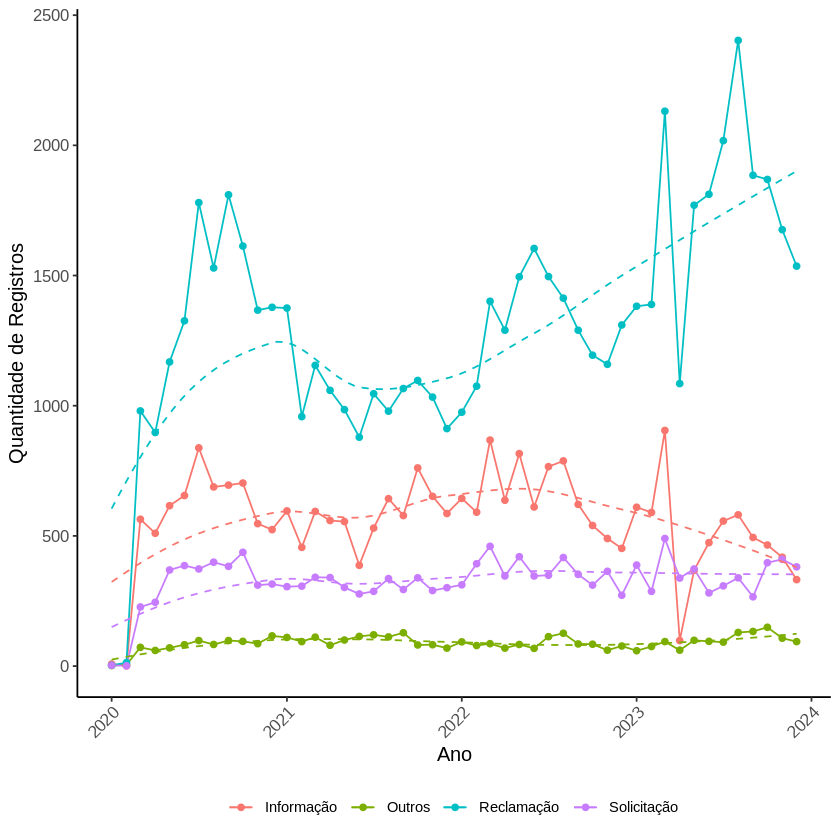

In [10]:
# gráfico da quantidade mensal de manifestações de cada tipo de manifestação
ggplot(tipo_manifestacao_agrupado, aes(x = data, y = soma, color = tipo_manifestacao)) +
  geom_line() +
  geom_point() +
  geom_smooth(aes(group = tipo_manifestacao), method = "loess", se = FALSE,
                  linetype = "dashed", size = 0.5) +
  theme_classic() +
  labs(x = "Ano",
       y = "Quantidade de Registros",
       color = "Tipo de Manifestação") +
  scale_x_date(
    breaks = seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"),
    labels = format(seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"), "%Y")
  ) +
  theme(
  legend.position = "bottom",
  axis.title = element_text(size = 12),
  axis.text = element_text(size = 10),
  axis.text.x = element_text(angle = 45, hjust = 1),
  legend.title = element_blank()
  )

In [11]:
# cálculo do total de manifestações de cada grupo de serviço
total_grupo_servico <- base_atendimento %>%
  group_by(grupo_servico) %>%
  summarise(soma = sum(qtd_manifestacao))

print(total_grupo_servico)

# A tibble: 11 × 2
   grupo_servico                      soma
   <chr>                             <dbl>
 1 Atendimento CAESB                 15068
 2 Denúncia                           3816
 3 Informações                        7617
 4 Não Informado                         3
 5 Não Pertence à CAESB                627
 6 Obras e Recomposições              8667
 7 Qualidade e Abastecimento          6514
 8 Serviços CAESB                      358
 9 Serviços Comerciais               59167
10 Serviços e Solicitações - Esgotos 13745
11 Serviços e Solicitações - Água    21390


In [12]:
# código para agrupar por grupo de serviço e listar os serviços
servicos_por_grupo <- base_atendimento %>%
  distinct(grupo_servico, servico) %>%
  group_by(grupo_servico) %>%
  summarize(servicos = paste(servico, collapse = "; "))

View(servicos_por_grupo)

grupo_servico,servicos
<chr>,<chr>
Atendimento CAESB,Ajuste e Melhoria de Procedimento; Atendimento Central 115; Atendimento Ouvidoria; Atendimento Sobre Recebimento Indevido de SMS; Cancelamento de Atendimento Ouvidoria; Conduta do Empregado Caesb; Conduta do Empregado no Corte; Conduta do Leiturista; Conduta Geral Sobre Atendimento; Crítica Atendimento do Escritório; Crítica Atendimento do Na Hora; Crítica Para Atendimento Caesb; Crítica Para Atendimento Central 115; Crítica Para Atendimento Ouvidoria; Demora Ligação Central 115; Demora Ligação Ouvidoria; Demora no Atendimento do Escritório; Demora no Atendimento do Na Hora; Elogio Atendimento Prestado Caesb; Elogio Atendimento Prestado Central 115; Elogio Atendimento Prestado Escritório/Na Hora; Elogio Atendimento Prestado Ouvidoria; Informação Sobre Atendimento Central 115; Informação Sobre Atendimento Ouvidoria; Lei de Acesso à Informação; Lei Geral de Proteção de Dados Pessoais; Melhoria de Procedimento; Procon-DF - Decisão fund. Não Atendida; Procon-DF - Decisão Reclamação Não Fundamentada; Procon-DF - Notif. Para Aud. de Conciliação; Procon-DF - Notif. Para Defesa Escrita; Site ou Aplicativo Caesb; Solicitação de Gravação Ouvidoria; Solicitação Gravação Central 115; Sugestão Geral
Denúncia,Água Servida/Esgoto; Condução de Veículo; Denúncia Geral; Denúncia Sobre Conduta de Empregado; Denúncia Sobre Fossa; Denúncia Sobre Fraude no Hidrômetro; Denúncia Sobre Violação de Corte; Desperdício de Água; Fornecimento de Água a Terceiros; Ligação Clandestina de Água; Ligação Clandestina de Esgotos; Poço Artesiano; Válvula ou Bloqueador de Ar; Furto de Hidrômetro
Informações,Informação Sobre Notificação; Informações Gerais; Concurso Público; Contatos Internos Caesb; Informações Gerais Sobre a Caesb; Ligação Incompleta ou muda; Engano de Ligação Telefônica; Interferência de Rede; Procedimentos de Corte; Teste de Telefonia; Unidades de Consumo
Não Informado,Não Informado
Não Pertence à CAESB,Assunto Não Pertinente à Caesb
Obras e Recomposições,Recomposição em Geral; Obras em Geral; Entulho Oriundo de Obras; Obras Outros Assuntos
Qualidade e Abastecimento,Análise da Qualidade da Água; Falta de Água; Abastecimento por Carro Pipa; Alta Pressão de Água; Baixa Pressão de Água; Rodízio de Abastecimento
Serviços CAESB,Estação de Tratamento; Serviços Internos Caesb
Serviços Comerciais,Alteração de Nome em Conta; Atendimento Comercial; Cobrança de Multa; Cobrança Faturamento Esgoto; Cobrança Multa Impedimento de Leitura; Cobrança Serviços Comerciais; Consumo Medido; Conta de Água Outros Assuntos; Débito - Outros Assuntos; Dados Cadastrais do Imóvel; Entrega da Conta / 2ª Via; Execução da Leitura; Parcelamento da Conta; Religação; Vistoria para Habite-se; Sinistro; Protesto em Cartório; Bônus Desconto; Corte - Outros Assuntos; Corte Indevido; Data da Leitura; Data de Vencimento da Conta; Débito em Conta Corrente; Funcionamento do Hidrômetro; Individualização de Ligação de Água; Pagamento Indevido; Reajuste de Tarifa; Restituição de Valores; Substituição Hidrômetro\Ligação em Massa; Transferência de Débitos; Verificação de Cobrança Sobre Corte; Cobrança Sobre Corte; Nova estrutura tarifária; Orçamento ligação de água e esgoto; Procedimentos Comerciais; Revisão de Conta


In [13]:
# cálculo do total de manifestações de cada canal de comunicação
total_comunicacao <- base_atendimento %>%
  group_by(canal_comunicacao) %>%
  summarise(soma = sum(qtd_manifestacao))

print(total_comunicacao)

# A tibble: 8 × 2
  canal_comunicacao      soma
  <chr>                 <dbl>
1 Caixa de Manifestação   125
2 Carta                    61
3 Demanda Interna         412
4 Fax                       4
5 Internet              41466
6 Presencial             1626
7 Telefone              92872
8 Whatsapp                406


In [14]:
# código para criar um novo dataframe provisório, que substitua os valores abaixo pela categoria "Outros"
base_provisoria <- base_atendimento %>%
  mutate(canal_comunicacao = case_when(
    canal_comunicacao == "Caixa de Manifestação" ~ "Outros",
    canal_comunicacao == "Carta" ~ "Outros",
    canal_comunicacao == "Demanda Interna" ~ "Outros",
    canal_comunicacao == "Fax" ~ "Outros",
    canal_comunicacao == "Whatsapp" ~ "Outros",
    TRUE ~ canal_comunicacao
  ))

# código para agrupar as quantidades de manifestações mensais pelo canal de comunicação
canal_comunicacao_agrupado <- base_provisoria %>%
  group_by(ano, mes_numero, canal_comunicacao) %>%
  summarize(soma = sum(qtd_manifestacao), .groups = "drop")

canal_comunicacao_agrupado <- na.omit(canal_comunicacao_agrupado)

print(canal_comunicacao_agrupado)

canal_comunicacao_agrupado$data <- make_date(canal_comunicacao_agrupado$ano, canal_comunicacao_agrupado$mes_numero, 1)

# A tibble: 237 × 4
     ano mes_numero canal_comunicacao  soma
   <dbl>      <dbl> <chr>             <dbl>
 1  2019          1 Internet            281
 2  2019          1 Presencial           19
 3  2019          1 Telefone           1038
 4  2019          2 Internet            348
 5  2019          2 Outros                3
 6  2019          2 Presencial           29
 7  2019          2 Telefone           1344
 8  2019          3 Internet            353
 9  2019          3 Outros                2
10  2019          3 Presencial           18
# ℹ 227 more rows


`geom_smooth()` using formula = 'y ~ x'


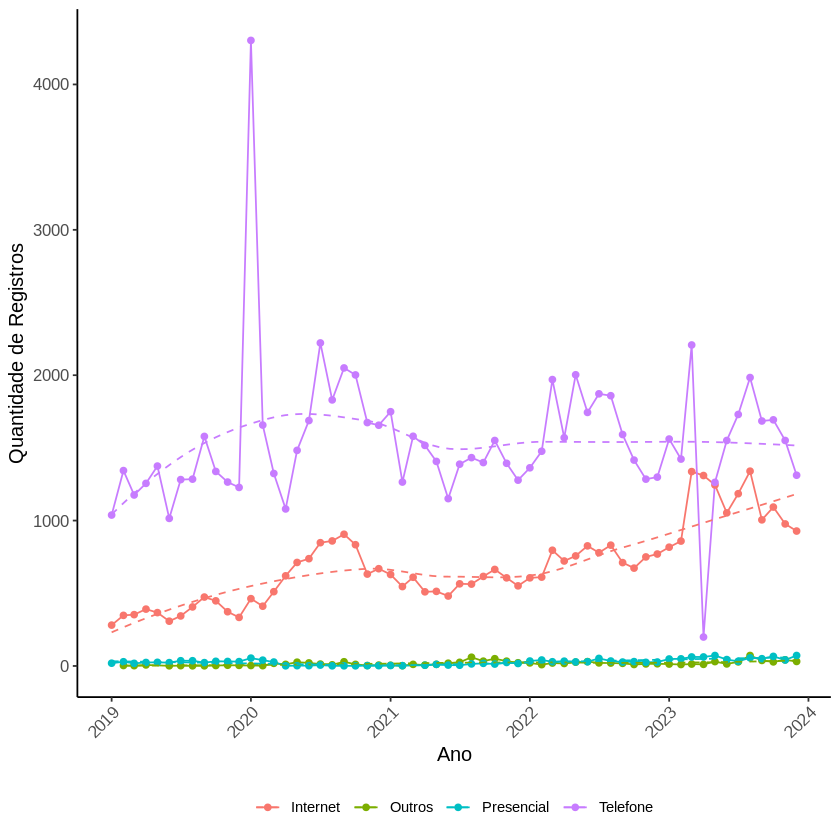

In [15]:
# gráfico da quantidade mensal de manifestações de cada canal de comunicação
ggplot(canal_comunicacao_agrupado, aes(x = data, y = soma, color = canal_comunicacao)) +
  geom_line() +
  geom_point() +
  theme_classic() +
  geom_smooth(aes(group = canal_comunicacao), method = "loess", se = FALSE,
                  linetype = "dashed", size = 0.5) +
  labs(x = "Ano",
       y = "Quantidade de Registros",
       color = "Canal de Comunicação") +
  scale_x_date(
    breaks = seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"),
    labels = format(seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"), "%Y")
  ) +
  theme(
  legend.position = "bottom",
  axis.title = element_text(size = 12),
  axis.text = element_text(size = 10),
  axis.text.x = element_text(angle = 45, hjust = 1),
  legend.title = element_blank()
  )

In [16]:
# cálculo do total de manifestações de cada órgão
total_orgao <- base_atendimento %>%
  group_by(orgao) %>%
  summarise(soma = sum(qtd_manifestacao))

print(total_orgao)

# A tibble: 17 × 2
   orgao                                   soma
   <chr>                                  <dbl>
 1 Adasa                                    915
 2 Administração Regional                    27
 3 Associação de Moradores do Lago Norte      7
 4 Caesb na Escuta                           43
 5 Correio Braziliense                       96
 6 Defensoria Pública                        41
 7 Defensoria Pública do DF                  52
 8 Ministério Público do DF                  99
 9 Novacap                                  140
10 Ouvidoria Geral do GDF                 20544
11 Ouvidoria [Cliente]                   111280
12 Ouvidoria [Funcionário]                  852
13 PRGI/COAUD                                36
14 Polícia Civil do DF                        2
15 Procon - DF                             1362
16 Procon - Outros Estados                    9
17 STC/E-Sic                               1467


In [17]:
# código para criar um novo dataframe provisório, que substitua os valores abaixo pela categoria "Outros"
base_provisoria <- base_atendimento %>%
  mutate(grupo_orgao = case_when(
    grupo_orgao == "Defesa do Consumidor" ~ "Outros",
    grupo_orgao == "Meios de Comunicação" ~ "Outros",
    grupo_orgao == "Serviços Públicos" ~ "Outros",
    grupo_orgao == "Associações Comunitárias" ~ "Outros",
    TRUE ~ grupo_orgao
  ))

# código para agrupar as quantidades de manifestações mensais pelo grupo de órgão
orgao_agrupado <- base_provisoria %>%
  group_by(ano, mes_numero, grupo_orgao) %>%
  summarize(soma = sum(qtd_manifestacao), .groups = "drop")

orgao_agrupado <- na.omit(orgao_agrupado)

print(orgao_agrupado)

orgao_agrupado$data <- make_date(orgao_agrupado$ano, orgao_agrupado$mes_numero, 1)

# A tibble: 120 × 4
     ano mes_numero grupo_orgao             soma
   <dbl>      <dbl> <chr>                  <dbl>
 1  2019          1 Atendimento ao Cidadão  1307
 2  2019          1 Outros                    31
 3  2019          2 Atendimento ao Cidadão  1682
 4  2019          2 Outros                    42
 5  2019          3 Atendimento ao Cidadão  1513
 6  2019          3 Outros                    36
 7  2019          4 Atendimento ao Cidadão  1630
 8  2019          4 Outros                    48
 9  2019          5 Atendimento ao Cidadão  1727
10  2019          5 Outros                    40
# ℹ 110 more rows


`geom_smooth()` using formula = 'y ~ x'


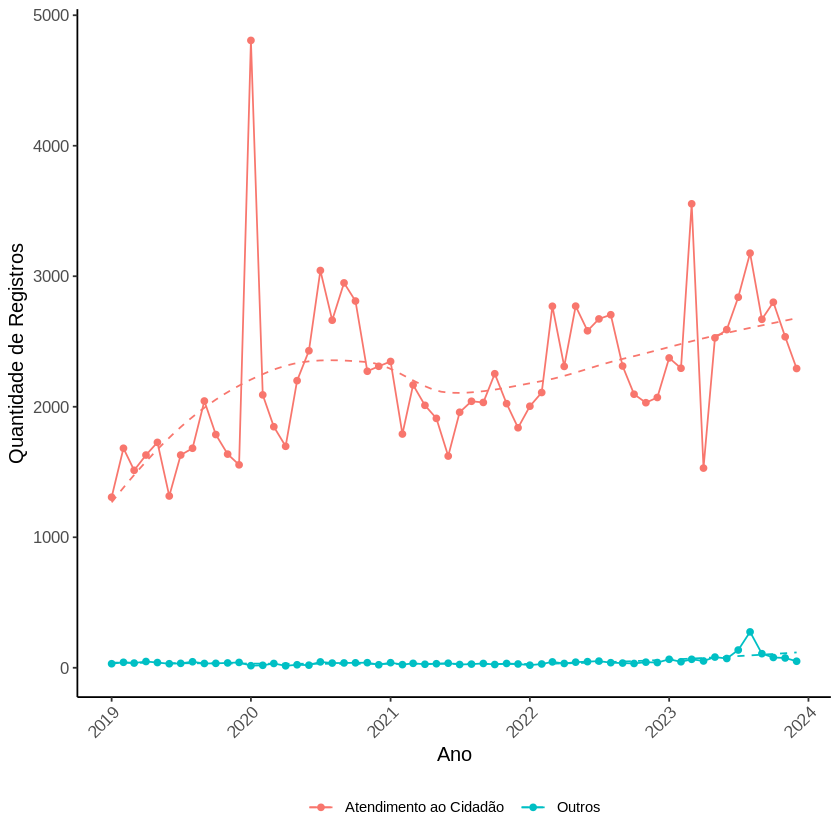

In [18]:
# gráfico da quantidade mensal de manifestações de cada grupo de órgão
ggplot(orgao_agrupado, aes(x = data, y = soma, color = grupo_orgao)) +
  geom_line() +
  geom_point() +
  theme_classic() +
  geom_smooth(aes(group = grupo_orgao), method = "loess", se = FALSE,
                  linetype = "dashed", size = 0.5) +
  labs(x = "Ano",
       y = "Quantidade de Registros",
       color = "Canal de Comunicação") +
  scale_x_date(
    breaks = seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"),
    labels = format(seq(from = as.Date("2019-01-01"), to = as.Date("2024-12-01"), by = "year"), "%Y")
  ) +
  theme(
  legend.position = "bottom",
  axis.title = element_text(size = 12),
  axis.text = element_text(size = 10),
  axis.text.x = element_text(angle = 45, hjust = 1),
  legend.title = element_blank()
  )

In [19]:
# cálculo do total de manifestações de cada tipo de cliente
total_cliente <- base_atendimento %>%
  group_by(tipo_cliente) %>%
  summarise(soma = sum(qtd_manifestacao))

total_cliente <- na.omit(total_cliente)
print(total_cliente)

# A tibble: 3 × 2
  tipo_cliente      soma
  <chr>            <dbl>
1 Dado Sigiloso     2955
2 Pessoa Física   103290
3 Pessoa Jurídica   3830


In [20]:
# informações de cada cidade com seu respectivo identificador de região administrativa
ra_codigo <- data.frame(
  cidade = c("Brasilia", "Noroeste", "Gama", "Taguatinga", "Brazlandia",
             "Sobradinho", "Planaltina", "Mestre Darmas", "Paranoa",
             "Nucleo Bandeirante", "Metropolitana - NB", "Ceilandia",
             "Guara", "Cruzeiro", "Samambaia", "Santa Maria",
             "São Sebastião", "Jardins Mangueiral", "Recanto das Emas",
             "Lago Sul", "Riacho Fundo", "Lago Norte", "SMLIN/SMLN Lago Norte",
             "Taquari/Lago Norte", "Candangolandia", "Aguas Claras",
             "Riacho Fundo II", "Octogonal", "Sudoeste", "Varjao",
             "Park Way", "St Compl Ind e Abastecimento", "Estrutural",
             "Sobradinho II", "Jardim Botanico", "Itapoa",
             "Setor de Ind e Abastecimento", "Vicente Pires", "Fercal",
             "Ceilandia II", "Arniqueira", "Arapoanga", "Agua Quente"),
  ra_cira = c(1, 1, 2, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14,
             14, 15, 16, 17, 18, 18, 18, 19, 20, 21, 22, 22, 23, 24,
             25, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35)
)

# código que adiciona a coluna com os identificadores ao base de dados de atendimento
base_atendimento <- left_join(base_atendimento, ra_codigo, by = "cidade")

summary(base_atendimento)

      ano           mes                 dia        tipo_manifestacao 
 Min.   :2019   Length:122511      Min.   : 1.00   Length:122511     
 1st Qu.:2020   Class :character   1st Qu.: 8.00   Class :character  
 Median :2021   Mode  :character   Median :16.00   Mode  :character  
 Mean   :2021                      Mean   :15.94                     
 3rd Qu.:2022                      3rd Qu.:23.00                     
 Max.   :2023                      Max.   :31.00                     
                                                                     
 grupo_servico        servico             cidade          canal_comunicacao 
 Length:122511      Length:122511      Length:122511      Length:122511     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                       

In [21]:
# cálculo do total de manifestações de cada região administrativa
total_codigo <- base_atendimento %>%
  group_by(ra_cira) %>%
  summarise(soma = sum(qtd_manifestacao)) %>%
  arrange(desc(soma))

print(total_codigo)

 # caso precise remover alguma coluna
 # base_atendimento <- base_atendimento %>% select(-ra_cira)

# A tibble: 36 × 2
   ra_cira  soma
     <dbl> <dbl>
 1       3 13197
 2       9 10246
 3      20  9894
 4      NA  9450
 5      30  8963
 6      12  8761
 7       1  8312
 8      10  6435
 9       6  5153
10      13  4593
# ℹ 26 more rows


In [22]:
# função para leitura de dados espaciais
df_shapefile <- st_read("/content/shapefile_distrito_federal.shp") # formatos: shx, shp e dbf

summary(df_shapefile)

Reading layer `shapefile_distrito_federal' from data source 
  `/content/shapefile_distrito_federal.shp' using driver `ESRI Shapefile'
Simple feature collection with 35 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 148001.1 ymin: 8222802 xmax: 252839.4 ymax: 8284705
CRS:           NA


    ra_cira       ra_nome           ra_codigo           ra_path         
 Min.   : 1.0   Length:35          Length:35          Length:35         
 1st Qu.: 9.5   Class :character   Class :character   Class :character  
 Median :18.0   Mode  :character   Mode  :character   Mode  :character  
 Mean   :18.0                                                           
 3rd Qu.:26.5                                                           
 Max.   :35.0                                                           
  created_us          created_da          last_edite       
 Length:35          Min.   :2023-05-15   Length:35         
 Class :character   1st Qu.:2023-05-15   Class :character  
 Mode  :character   Median :2023-05-15   Mode  :character  
                    Mean   :2023-05-15                     
                    3rd Qu.:2023-05-15                     
                    Max.   :2023-05-15                     
   last_edi_1           gdb_archiv      gdb_from_d           gdb_to_d

In [23]:
# código para calcular a quantidade de manifestações de cada região administrativa
quantidade_cidade <- base_atendimento %>%
  group_by(ra_cira) %>%
  summarize(total_quantidade = sum(qtd_manifestacao))

# código para adicionar as quantidades aferidas a serem utilizadas no mapa do DF
df_completo <- df_shapefile %>%
  left_join(quantidade_cidade, by = "ra_cira")

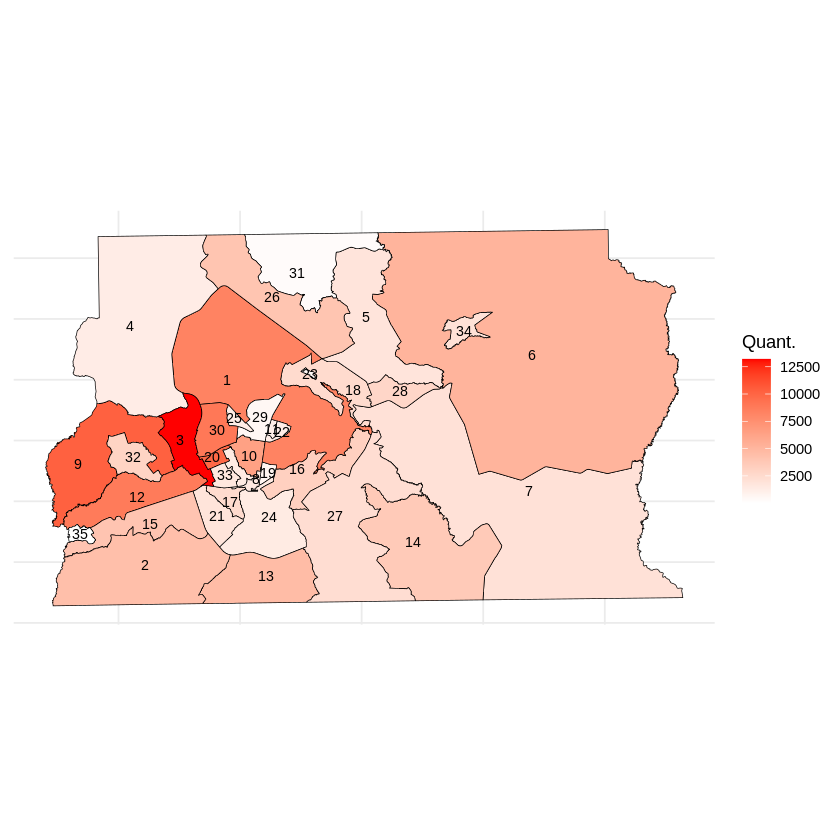

In [24]:
# Gráfico da Distribuição de manifestações entre as Regiões Administrativas do DF
ggplot(data = df_completo) +
  geom_sf(aes(fill = total_quantidade), color = "black") +
  scale_fill_gradient2(low = "black", mid = "white", high = "red", midpoint = 15) +
  theme_minimal() +
  labs(
    fill = "Quant."
  ) +
  geom_sf_text(aes(label = ra_cira), size = 3, color = "black") +
  theme(
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks = element_blank(),
    axis.line = element_blank(),
    panel.border = element_blank()
  )

In [25]:
# código para identificar os grupos de serviços mais solicitados das regiões administrativas
top_servicos <- base_atendimento %>%
  group_by(ra_cira, grupo_servico) %>%
  summarise(total = sum(qtd_manifestacao)) %>%
  arrange(ra_cira, desc(total)) %>%
  group_by(ra_cira) %>%
  slice_head(n = 12) # todos blocos de serviços

print(top_servicos)

`summarise()` has grouped output by 'ra_cira'. You can override using the
`.groups` argument.


# A tibble: 349 × 3
# Groups:   ra_cira [36]
   ra_cira grupo_servico                     total
     <dbl> <chr>                             <dbl>
 1       1 Serviços Comerciais                3650
 2       1 Serviços e Solicitações - Água     1029
 3       1 Atendimento CAESB                   965
 4       1 Serviços e Solicitações - Esgotos   789
 5       1 Qualidade e Abastecimento           565
 6       1 Obras e Recomposições               520
 7       1 Informações                         517
 8       1 Denúncia                            200
 9       1 Não Pertence à CAESB                 53
10       1 Serviços CAESB                       23
# ℹ 339 more rows


**Etapa 2: Análise das Pesquisas de Satisfação dos Usuários**

Nesta etapa, utilizou-se a base de dados com informações das pesquisas.

In [26]:
# função para efetuar a leitura da planilha do Excel
base_pesquisa <- read_xlsx("db_pesquisa.xlsx")

# função para obter um resumo estatístico do banco de dados
summary(base_pesquisa)

# calculando quantos participantes
sum(base_pesquisa$participacao)

      ano        participacao    qualidade_agua avaliacao_quali_agua
 Min.   :2022   Min.   :0.0000   Min.   :1.00   Length:1630         
 1st Qu.:2023   1st Qu.:1.0000   1st Qu.:4.00   Class :character    
 Median :2023   Median :1.0000   Median :5.00   Mode  :character    
 Mean   :2023   Mean   :0.9699   Mean   :4.48                       
 3rd Qu.:2023   3rd Qu.:1.0000   3rd Qu.:5.00                       
 Max.   :2024   Max.   :1.0000   Max.   :5.00                       
                                 NA's   :49                         
 continuidade_abastecimento_agua avaliacao_abastecimento sistema_esgoto 
 Min.   :1.000                   Length:1630             Min.   :1.000  
 1st Qu.:4.000                   Class :character        1st Qu.:3.000  
 Median :5.000                   Mode  :character        Median :4.000  
 Mean   :4.474                                           Mean   :3.777  
 3rd Qu.:5.000                                           3rd Qu.:5.000  
 Max.   :5

[1] 1581

In [27]:
# código para calcular a média anual dos indicadores
media_anual <- base_pesquisa %>%
  group_by(ano) %>%
  summarise(
    qualidade_agua = mean(qualidade_agua, na.rm = TRUE),
    continuidade_abastecimento_agua = mean(continuidade_abastecimento_agua, na.rm = TRUE),
    sistema_esgoto = mean(sistema_esgoto, na.rm = TRUE),
    imagem_caesb = mean(imagem_caesb, na.rm = TRUE),
    atendimento_prestado = mean(atendimento_prestado, na.rm = TRUE),
    prazo_atendimento = mean(prazo_atendimento, na.rm = TRUE),
    qualidade_servico = mean(qualidade_servico, na.rm = TRUE),
    postura_agente = mean(postura_agente, na.rm = TRUE),
    .groups = "drop"
  )

print(media_anual)

# A tibble: 3 × 9
    ano qualidade_agua continuidade_abastecimento_…¹ sistema_esgoto imagem_caesb
  <dbl>          <dbl>                         <dbl>          <dbl>        <dbl>
1  2022           4.38                          4.46           3.75         4.06
2  2023           4.51                          4.46           3.82         3.98
3  2024           4.52                          4.53           3.72         3.96
# ℹ abbreviated name: ¹​continuidade_abastecimento_agua
# ℹ 4 more variables: atendimento_prestado <dbl>, prazo_atendimento <dbl>,
#   qualidade_servico <dbl>, postura_agente <dbl>


In [28]:
# código para transformar os dados para formato longo
media_anual <- media_anual %>%
  pivot_longer(cols = -ano,
               names_to = "indicador",
               values_to = "valor")

# código para reorganizar os dados para ter os anos como colunas e indicadores nas linhas
media_anual <- media_anual %>%
  pivot_wider(names_from = ano,   # Transformar 'ano' em colunas
              values_from = valor)  # Usar 'valor' como o conteúdo das colunas

print(media_anual)

# A tibble: 8 × 4
  indicador                       `2022` `2023` `2024`
  <chr>                            <dbl>  <dbl>  <dbl>
1 qualidade_agua                    4.38   4.51   4.52
2 continuidade_abastecimento_agua   4.46   4.46   4.53
3 sistema_esgoto                    3.75   3.82   3.72
4 imagem_caesb                      4.06   3.98   3.96
5 atendimento_prestado              4.10   3.91   4.03
6 prazo_atendimento                 3.72   3.56   3.68
7 qualidade_servico                 4.04   3.98   4.03
8 postura_agente                    4.34   4.37   4.34


In [29]:
# código para renomear os indicadores
media_anual <- media_anual %>%
  mutate(indicador = recode(indicador,
                            "qualidade_agua" = "qualidade da água",
                            "continuidade_abastecimento_agua" = "continuidade do abastecimento de água",
                            "sistema_esgoto" = "sistema de esgoto",
                            "imagem_caesb" = "imagem da CAESB",
                            "atendimento_prestado" = "atendimento prestado",
                            "prazo_atendimento" = "prazo de atendimento",
                            "qualidade_servico" = "qualidade dos serviços",
                            "postura_agente" = "postura dos agentes"))

print(media_anual)

# A tibble: 8 × 4
  indicador                             `2022` `2023` `2024`
  <chr>                                  <dbl>  <dbl>  <dbl>
1 qualidade da água                       4.38   4.51   4.52
2 continuidade do abastecimento de água   4.46   4.46   4.53
3 sistema de esgoto                       3.75   3.82   3.72
4 imagem da CAESB                         4.06   3.98   3.96
5 atendimento prestado                    4.10   3.91   4.03
6 prazo de atendimento                    3.72   3.56   3.68
7 qualidade dos serviços                  4.04   3.98   4.03
8 postura dos agentes                     4.34   4.37   4.34


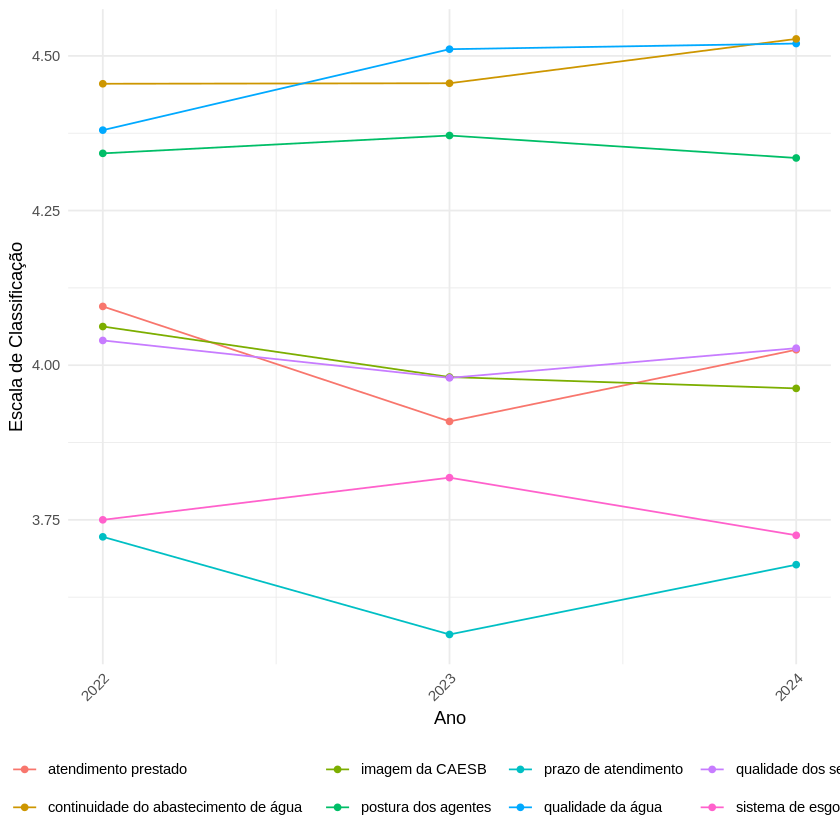

In [30]:
# código para transformar dados de um formato "largo" (wide) para um formato "longo" (long)
dados_long <- melt(media_anual, id.vars = "indicador", variable.name = "ano", value.name = "valor")
dados_long$ano <- as.numeric(gsub("X", "", dados_long$ano))

# código para criar o gráfico da média anual dos indicadores
ggplot(dados_long, aes(x = ano, y = valor, group = indicador, color = indicador)) +
  geom_line() +
  geom_point(size = 1.5) +
  labs(x = "Ano",
       y = "Escala de Classificação") +
  theme_minimal() +
  scale_x_continuous(breaks = seq(min(dados_long$ano), max(dados_long$ano), by = 1)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom",
        legend.title = element_blank())

Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 49 rows containing non-finite outside the scale range
(`stat_density()`).”


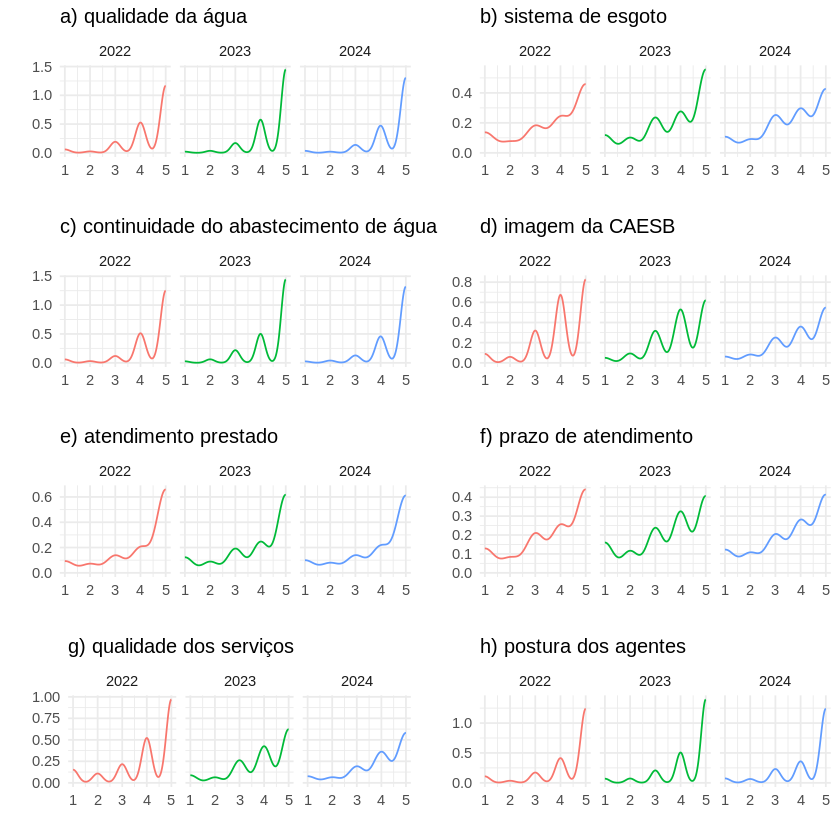

In [48]:
# código para criar o gráfico de densidade dos indicadores em cada ano
plot1 <- ggplot(base_pesquisa, aes(x = qualidade_agua, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "a) qualidade da água",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot3 <- ggplot(base_pesquisa, aes(x = continuidade_abastecimento_agua, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "c) continuidade do abastecimento de água",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot2 <- ggplot(base_pesquisa, aes(x = sistema_esgoto, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "b) sistema de esgoto",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot4 <- ggplot(base_pesquisa, aes(x = imagem_caesb, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "d) imagem da CAESB",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot5 <- ggplot(base_pesquisa, aes(x = atendimento_prestado, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "e) atendimento prestado",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot6 <- ggplot(base_pesquisa, aes(x = prazo_atendimento, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "f) prazo de atendimento",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot7 <- ggplot(base_pesquisa, aes(x = qualidade_servico, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "g) qualidade dos serviços",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

plot8 <- ggplot(base_pesquisa, aes(x = postura_agente, color = as.factor(ano))) +
  geom_density(alpha = 0.5) +
  labs(title = "h) postura dos agentes",
       x = "",
       y = "",
       color = "") +
  theme_minimal() +
  facet_wrap(~ ano) +
  theme(legend.position = "none", plot.title = element_text(size = 12))

grid.arrange(plot1, plot2, plot3, plot4,
plot5, plot6, plot7, plot8, ncol = 2)

In [50]:
# código para definir as colunas para aplicar o teste de Kruskal Wallis
filtro <- c("qualidade_agua", "continuidade_abastecimento_agua",
"sistema_esgoto", "imagem_caesb", "atendimento_prestado", "prazo_atendimento",
"qualidade_servico", "postura_agente")

# código para criar uma tabela vazia para armazenar os resultados do teste de Kruskal Wallis
resultados_kruskal <- data.frame(
  indicador = character(),   # Nome do indicador
  chi_squared = numeric(),   # Estatístico H
  df = numeric(),            # Graus de liberdade (df)
  p_value = numeric(),       # Valor p
  stringsAsFactors = FALSE   # Evita conversão para fatores
)

# código para aplicar o teste de Kruskal-Wallis nas colunas selecionadas
for (variavel in filtro) {
  if (is.numeric(base_pesquisa[[variavel]])) {
        kruskal_result <- kruskal.test(base_pesquisa[[variavel]] ~ base_pesquisa$ano)

    resultados_kruskal <- rbind(resultados_kruskal, data.frame(
      indicador = variavel,             # Nome da variável
      chi_squared = kruskal_result$statistic,  # Estatístico H
      df = kruskal_result$parameter,    # Graus de liberdade
      p_value = kruskal_result$p.value       # Valor p
    ))
  } else {
    message(paste("A variável", variavel, "não é numérica."))
  }
}

head(resultados_kruskal, n = 8)

#  Teste de Kruskall-Wallis
# H0: não existe diferença significativa entre os grupos
# Ha: pelo menos um dos grupos difere significativamente dos demais

,indicador,chi_squared,df,p_value
,<chr>,<dbl>,<int>,<dbl>
Kruskal-Wallis chi-squared,qualidade_agua,5.8916668,2,0.05255824
Kruskal-Wallis chi-squared1,continuidade_abastecimento_agua,1.7076600,2,0.42578107
Kruskal-Wallis chi-squared2,sistema_esgoto,2.5167771,2,0.28411149
Kruskal-Wallis chi-squared3,imagem_caesb,2.3560313,2,0.30788909
Kruskal-Wallis chi-squared4,atendimento_prestado,7.5097968,2,0.02340283
Kruskal-Wallis chi-squared5,prazo_atendimento,5.1350742,2,0.07672428
Kruskal-Wallis chi-squared6,qualidade_servico,3.2052350,2,0.20136874
Kruskal-Wallis chi-squared7,postura_agente,0.0399529,2,0.98022175


***Lembrando que:***

Quando o *p*-valor é maior que 0.05, devemos aceitar a hipótese nula;

Quando o *p*-valor é menor que 0.05, devemos rejeitar a hipótese nula.

In [51]:
# código para aplicar o teste de Dunn
dunn_resultados <- dunn_test(atendimento_prestado ~ ano, data = base_pesquisa, p.adjust.method = "bonferroni")
View(dunn_resultados)

,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1,atendimento_prestado,2022,2023,400,781,-2.6126921,0.00898322,0.02694966,*
2,atendimento_prestado,2022,2024,400,400,-0.8259045,0.40885828,1.00000000,ns
3,atendimento_prestado,2023,2024,781,400,1.6628632,0.09633983,0.28901949,ns


In [52]:
# código para selecionar as colunas específicas
total_opiniao <- base_pesquisa[, c("avaliacao_quali_agua",
"avaliacao_abastecimento", "avaliacao_esgoto", "avaliacao_imagem",
"avaliacao_atendimento", "avaliacao_prazo", "avaliacao_servico",
"avaliacao_agente", "opiniao")]

In [53]:
# código para juntar as opiniões dos indicadores com a coluna de opinião
base_pesquisa$total_opiniao <- apply(total_opiniao, 1, function(x) {

  partes <- x[x != "" & !is.na(x)]
  resultado <- paste(partes, collapse = " ")
  if (nchar(resultado) > 0 && !grepl("\\.$", resultado)) {
    resultado <- paste0(resultado, ".")
  }

  return(resultado)
})

In [54]:
# código para criar um corpus a partir da coluna de total_opiniao
corpus <- Corpus(VectorSource(base_pesquisa$total_opiniao))

# código para limpar o texto
corpus <- tm_map(corpus, content_transformer(tolower))      # converter texto em minúsculas
corpus <- tm_map(corpus, removePunctuation)                 # remover pontuação
corpus <- tm_map(corpus, removeNumbers)                     # remover números
corpus <- tm_map(corpus, removeWords, stopwords("pt"))      # remover stopwords (em português)
corpus <- tm_map(corpus, stripWhitespace)                   # remover espaços extras

# código para criar a matriz de termos (frequência de palavras)
tdm <- TermDocumentMatrix(corpus)

# código par converter a TDM em uma matriz
m <- as.matrix(tdm)
word_freqs <- sort(rowSums(m), decreasing = TRUE)
word_freq_table <- data.frame(word = names(word_freqs), freq = word_freqs)

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("pt")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”


In [55]:
# código para visualizar as palavras e as respectivas frequências
head(word_freq_table, n = 5)
nrow(word_freq_table)

,word,freq
,<chr>,<dbl>
atendimento,atendimento,464
demora,demora,271
deseja,deseja,263
esgoto,esgoto,155
melhorar,melhorar,142


[1] 1191

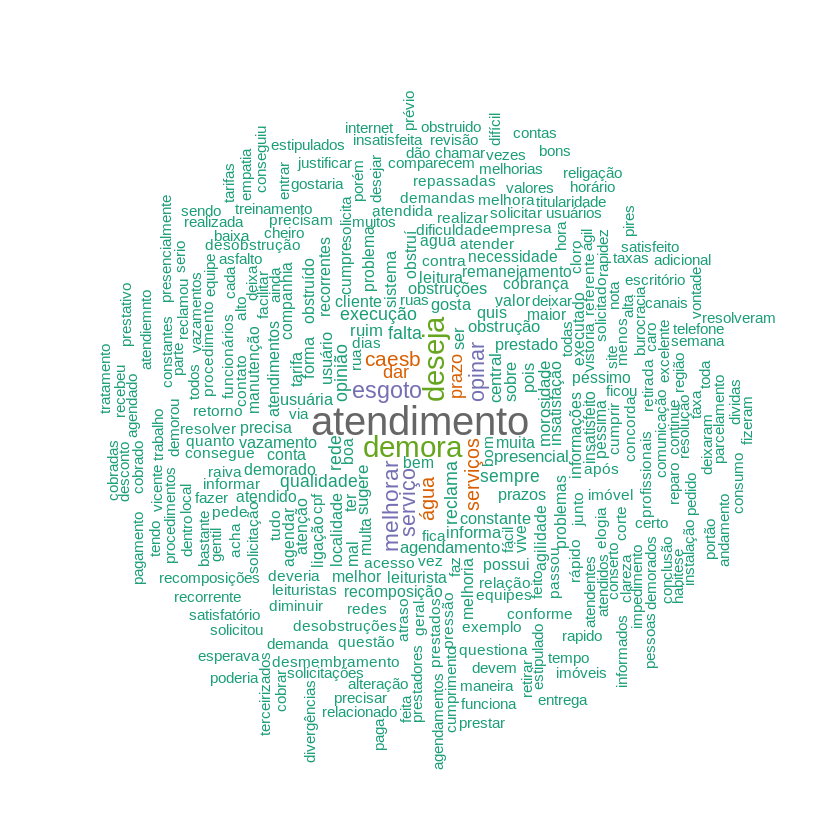

In [56]:
# código para criar o gráfico de nuvem de palavras
wordcloud(words = word_freq_table$word, freq = word_freq_table$freq,
          max.words = 300, min.freq = 1, random.order = F, rot.per = 0.5,
          scale = c(2,0.75), colors = brewer.pal(8, "Dark2"))

***Obs.:*** Antes de realizar a análise de sentimentos, é preciso traduzir o texto de interesse para a língua inglesa. Como há problemas com o pacote "reticulate" no Colab, foi necessário outro Colab em Python para traduzir a coluna desejada.

Após a tradução, o banco de dados resultante foi adicionado ao presente Colab e, consequentemente, utilizado para a análise de sentimento.

In [57]:
# código para preparar o upload da base de dados
write.xlsx(base_pesquisa, "database_pesquisa.xlsx")

In [58]:
# código para preparar o upload da base de dados traduzir (após a tradução no Python)
download.file("https://github.com/oliveira-ls/caesb-database-research/raw/refs/heads/main/database-translate/db_pesq_complete.xlsx",
destfile = "db_pesq_complete.xlsx", mode = "wb")

In [59]:
# função para efetuar a leitura da planilha do Excel
base_traducao_pesquisa <- read_xlsx("db_pesq_complete.xlsx")

# função para obter um resumo estatístico do banco de dados
summary(base_traducao_pesquisa)

      ano        participacao    qualidade_agua avaliacao_quali_agua
 Min.   :2022   Min.   :0.0000   Min.   :1.00   Length:1630         
 1st Qu.:2023   1st Qu.:1.0000   1st Qu.:4.00   Class :character    
 Median :2023   Median :1.0000   Median :5.00   Mode  :character    
 Mean   :2023   Mean   :0.9699   Mean   :4.48                       
 3rd Qu.:2023   3rd Qu.:1.0000   3rd Qu.:5.00                       
 Max.   :2024   Max.   :1.0000   Max.   :5.00                       
                                 NA's   :49                         
 continuidade_abastecimento_agua avaliacao_abastecimento sistema_esgoto 
 Min.   :1.000                   Length:1630             Min.   :1.000  
 1st Qu.:4.000                   Class :character        1st Qu.:3.000  
 Median :5.000                   Mode  :character        Median :4.000  
 Mean   :4.474                                           Mean   :3.777  
 3rd Qu.:5.000                                           3rd Qu.:5.000  
 Max.   :5

In [60]:
# código para analisar os sentimentos da coluna traducao
sentimento <- get_nrc_sentiment(base_traducao_pesquisa$traducao)
head(sentimento, n = 5)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,0,1,0,1,1,0


In [61]:
# código para filtrar as linhas que não têm sentimentos (onde todos os sentimentos são 0)
sentimento_filtrado <- sentimento[rowSums(sentimento) > 0, ]

# código para verificar a quantidade total de opiniões que possuem algum sentimento
nrow(sentimento_filtrado)

# código para calcular a média de cada emoção
media_sentimentos <- colMeans(sentimento_filtrado)

# código para adicionar os nomes dos sentimentos em português
nomes_sentimentos <- c("raiva", "antecipação", "desgosto", "medo", "alegria",
"tristeza", "surpresa", "confiança", "negativo", "positivo")

# código para modificar os nomes das colunas para português
names(media_sentimentos) <- nomes_sentimentos

[1] 650

In [62]:
# código para criar um dataframe para o gráfico de radar
radar_data <- as.data.frame(t(media_sentimentos)) # Transpor as médias para as linhas

# código para adicionar uma linha com os valores máximos e mínimos
radar_data <- rbind(rep(1, ncol(radar_data)),  # Linha de valores máximos
                    rep(0, ncol(radar_data)),  # Linha de valores mínimos
                    radar_data)  # Linha com as médias reais

# código para nomear as colunas (emoções)
colnames(radar_data) <- names(media_sentimentos)

head(radar_data)

,raiva,antecipação,desgosto,medo,alegria,tristeza,surpresa,confiança,negativo,positivo
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.00,1.0000000,1.0000000,1.0000000,1.00,1.0000000,1.00000000,1.0000000,1.0000000,1.0000000
2,0.00,0.0000000,0.0000000,0.0000000,0.00,0.0000000,0.00000000,0.0000000,0.0000000,0.0000000
3,0.42,0.5476923,0.5615385,0.4646154,0.36,0.4461538,0.06769231,0.6938462,0.9461538,0.8384615


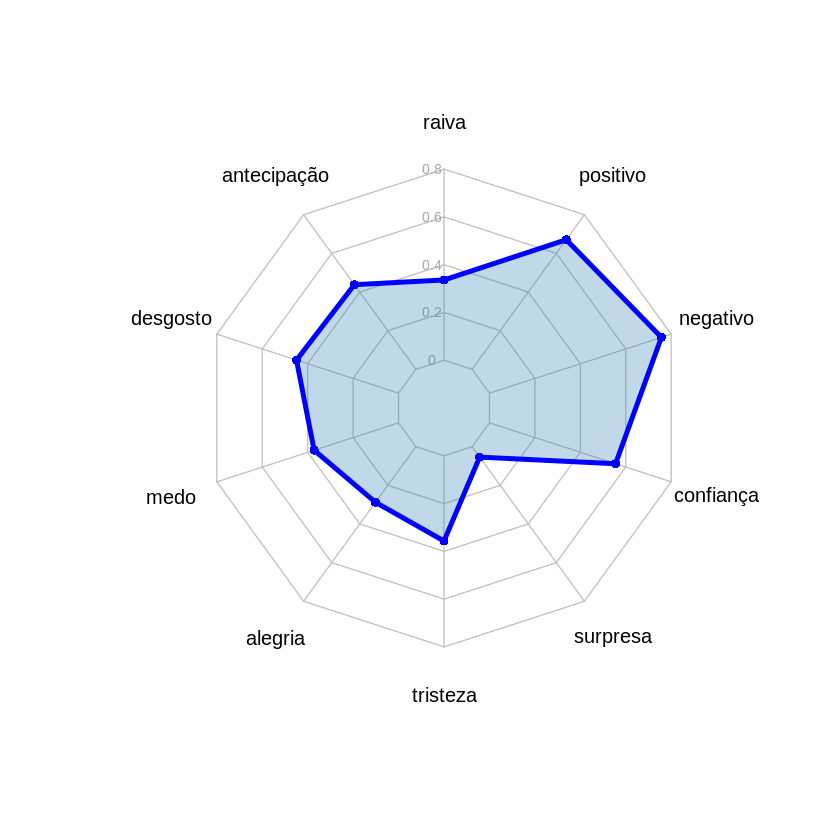

In [63]:
# código para criar o gráfico de radar
radarchart(radar_data, axistype = 1,
           pcol = "blue", pfcol = rgb(0.2, 0.5, 0.7, 0.3), plwd = 4,
           cglcol = "gray", cglty = 1, axislabcol = "darkgray",
           caxislabels = seq(0, 1, 0.2), calcex = 0.7)